In [1]:
import matplotlib.pyplot as plt
import numpy as np
from stop_all import disable_all_power
import pyvisa
from windfreak import SynthHD
import nidaqmx
from nidaqmx.constants import TerminalConfiguration
from NRP50S import NRP50S
from SPD3303X import SPD3303X
from utils import check_voltage, watt_to_dBm
import time
import tqdm
import csv
from typing import List, Tuple

In [2]:
def switch_spdt(amplifier: str, channel: int, device: str):
    if amplifier == "vg1" or amplifier == "a1":
        voltage = 0
    elif amplifier == "vg2" or amplifier == "a2":
        voltage = 5
    else:
        raise ValueError(f"amplifier is {amplifier}; not vg1 or vg2")
        
    with nidaqmx.Task() as task:
        task.ao_channels.add_ao_voltage_chan(
            f"{device}/ao{channel}", min_val = 0, max_val = 5
        )
        task.write(voltage)

In [3]:
def enable_40GHz_power_for_scan(
    psu_a_5pos: SPD3303X, psu_12pos_vd_5neg: SPD3303X, dt: float = 2
):
    psu_12pos_vd_5neg.ch1_voltage_setpoint = 12
    psu_12pos_vd_5neg.ch1_current_setpoint = 3.0
    psu_12pos_vd_5neg.output(True, 1)
    time.sleep(dt)
    assert check_voltage(psu_12pos_vd_5neg.ch1_voltage, 12.0)

    # enable +/- 5V for the SPDT switches
    psu_a_5pos.output(True, 3)
    psu_12pos_vd_5neg.output(True, 3)

    # enable amplifiers
    psu_a_5pos.ch1_voltage_setpoint = 6
    psu_a_5pos.ch1_current_setpoint = 3.2

    psu_a_5pos.ch2_voltage_setpoint = 6
    psu_a_5pos.ch2_current_setpoint = 3.2

    psu_a_5pos.output(True, 1)
    psu_a_5pos.output(True, 2)
    time.sleep(dt)
    assert check_voltage(psu_a_5pos.ch1_voltage, 6)
    assert check_voltage(psu_a_5pos.ch2_voltage, 6)

def disable_40GHz_power(
    psu_a_5pos: SPD3303X, psu_12pos_vd_5neg: SPD3303X, dt: float = 2
):
    # disable +5V for the SPDT switches
    psu_a_5pos.output(False, 3)
    psu_12pos_vd_5neg.output(False, 3)

    # disable 12V for the 40 GHz amplifiers
    psu_a_5pos.ch1_voltage_setpoint = 0.0
    psu_a_5pos.ch2_voltage_setpoint = 0.0

    psu_a_5pos.output(False, 1)
    psu_a_5pos.output(False, 2)

    time.sleep(dt)
    assert check_voltage(psu_a_5pos.ch1_voltage, 0.0)
    assert check_voltage(psu_a_5pos.ch2_voltage, 0.0)

    psu_12pos_vd_5neg.ch1_voltage_setpoint = 0
    psu_12pos_vd_5neg.output(False, 1)

    time.sleep(dt)
    assert check_voltage(psu_12pos_vd_5neg.ch1_voltage, 0.0)

In [4]:
resource_name_daq = "Dev1"
resource_name_power_meter = "USB0::0x0AAD::0x0161::101074::INSTR"
psu_vg_5pos = "USB0::0xF4EC::0x1430::SPD3XIDX5R3677::INSTR"
psu_12pos_vd_5neg = "USB0::0xF4EC::0x1430::SPD3XIED5R7612::INSTR"
psu_a_5pos = "USB0::0xF4EC::0x1430::SPD3XIED5R8368::INSTR"
resource_name_windfreak = "COM5"

power_meter = NRP50S(resource_name_power_meter)
psu_vg_5pos = SPD3303X(psu_vg_5pos)
psu_12pos_vd_5neg = SPD3303X(psu_12pos_vd_5neg)
psu_a_5pos = SPD3303X(psu_a_5pos)
synthd = SynthHD(resource_name_windfreak)


In [5]:
synthd[1].frequency = 40e9/4
synthd[1].power = 0

# set to vg2
switch_spdt("a1", 0, resource_name_daq)


power_meter.frequency = synthd[1].frequency*4
power_meter._write("UNIT:POW DBM")

In [10]:
scan_data: List[Tuple[float, float, float, float]] = []

synthd[1].enable = True
enable_40GHz_power_for_scan(psu_a_5pos, psu_12pos_vd_5neg)

# set to a2
switch_spdt("a1", 0, resource_name_daq)

for a1 in tqdm.tqdm(np.linspace(3, 12, 51)):
    psu_a_5pos.ch1_voltage_setpoint = a1
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append((a1, np.mean(p), psu_a_5pos.ch2_power, psu_a_5pos.ch1_current))

disable_40GHz_power(psu_a_5pos, psu_12pos_vd_5neg)
synthd[1].enable = False


100%|██████████| 51/51 [02:10<00:00,  2.56s/it]


In [11]:
with open("2023_2_10_a1.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(["A1 [V]", "det power [dBm]", "amp current [A]", "amp power [W]"])
    for row in scan_data:
        writer.writerow(row)

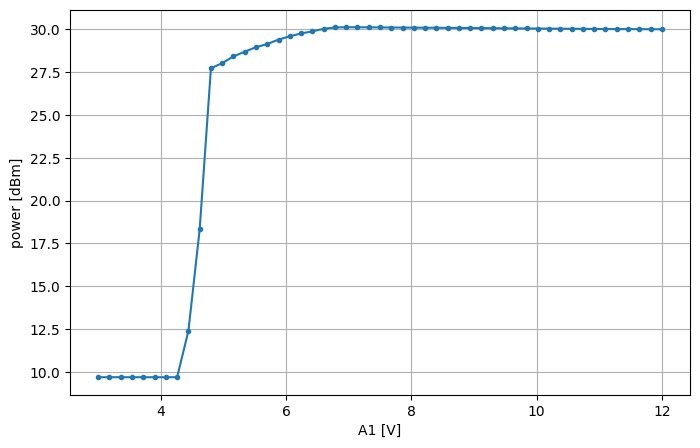

In [12]:
a1, det, ac, ap = np.asarray(list(zip(*scan_data)))
det += 20

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(a1,det, '.-')

ax.set_xlabel("A1 [V]")
ax.set_ylabel("power [dBm]")
ax.grid(True)

## Scan Output power over time

In [13]:
scan_data: List[Tuple[float, float, float, float]] = []

synthd[1].enable = True
enable_40GHz_power_for_scan(psu_a_5pos, psu_12pos_vd_5neg)

# set to a2
switch_spdt("a1", 0, resource_name_daq)

psu_a_5pos.ch1_voltage_setpoint = 12.0

start_time = time.time()
dt = 10.0
for _ in tqdm.tqdm(range(int(6 * 60 / dt))):
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append(
        (
            time.time() - start_time,
            np.mean(p),
            psu_a_5pos.ch2_power,
            psu_a_5pos.ch2_current,
        )
    )
    time.sleep(8)

disable_40GHz_power(psu_a_5pos, psu_12pos_vd_5neg)
synthd[1].enable = False


100%|██████████| 36/36 [06:20<00:00, 10.56s/it]


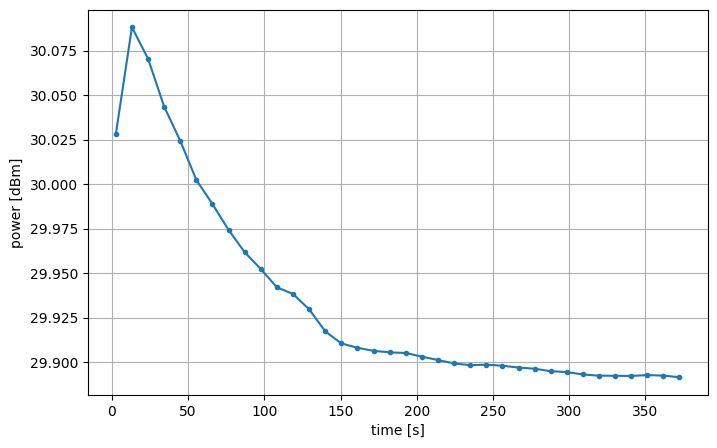

In [14]:
t, det, ac, ap = np.asarray(list(zip(*scan_data)))
det += 20

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t,det, '.-')

ax.set_xlabel("time [s]")
ax.set_ylabel("power [dBm]")
ax.grid(True)

In [15]:
with open("2023_2_10_a1_power_time.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(["time [s]", "det power [dBm]", "amp current [A]", "amp power [W]"])
    for row in scan_data:
        writer.writerow(row)

# Scan SynthHD Output power

In [20]:
scan_data: List[Tuple[float, float, float, float, float]] = []

# set to vg2
switch_spdt("a1", 0, resource_name_daq)

synthd[1].power = 0
synthd[1].enable = True
enable_40GHz_power_for_scan(psu_a_5pos, psu_12pos_vd_5neg)
psu_a_5pos.ch1_voltage_setpoint = 12.0

for shdpower in tqdm.tqdm(np.linspace(-30, -5, 101)):
    synthd[1].power = shdpower
    p = []
    for _ in range(5):
        power_meter._write("RST")
        power_meter.initiate()
        time.sleep(0.5)
        p.append(power_meter.fetch())
    scan_data.append((shdpower, np.mean(p), psu_a_5pos.ch2_power, psu_a_5pos.ch2_current))

disable_40GHz_power(psu_a_5pos, psu_12pos_vd_5neg)
synthd[1].power = -20
synthd[1].enable = False


100%|██████████| 101/101 [04:18<00:00,  2.56s/it]


In [21]:
with open("2023_2_10_a1_synthd_power.csv", "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerow(["synthHD Pro power [W]", "det power [dBm]", "amp current [A]", "amp power [W]"])
    for row in scan_data:
        writer.writerow(row)

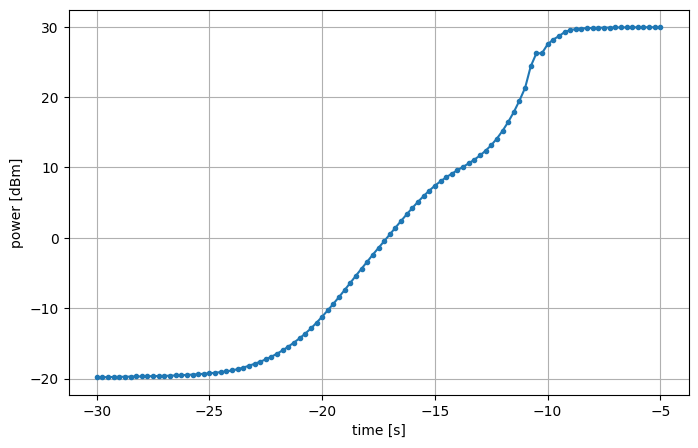

In [22]:
t, det, ac, ap = np.asarray(list(zip(*scan_data)))
det += 20

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t,det, '.-')

ax.set_xlabel("time [s]")
ax.set_ylabel("power [dBm]")
ax.grid(True)